In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import os

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Path to your dataset
dataset_path = '/content/drive/MyDrive/Train_Test_Split'

# ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalization and split

# Define a subset size for quicker runs
subset_size = 0.1  # Use 10% of the dataset for training and validation

In [ ]:
# Load training and validation data with a subset of the dataset
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 5546 images belonging to 2 classes.
Found 1385 images belonging to 2 classes.


In [ ]:
# Get a subset of the data
def get_data(generator, num_batches):
    data, labels = [], []
    for _ in range(num_batches):
        batch_data, batch_labels = next(generator)
        data.append(batch_data)
        labels.append(batch_labels)
    return np.vstack(data), np.hstack(labels)

x_train_subset, y_train_subset = get_data(train_generator, num_batches=5)
x_val_subset, y_val_subset = get_data(validation_generator, num_batches=2)

In [ ]:
# Define the LeNet-5 model
def create_lenet5_model(optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(64, 64, 3), kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation='tanh', kernel_initializer='uniform'))
    model.add(Dense(84, activation='tanh', kernel_initializer='uniform'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Wrap the model using KerasClassifier
model = KerasClassifier(model=create_lenet5_model, verbose=0)

# Define hyperparameters for tuning (removed 'init_mode' here)
param_dist = {
    'batch_size': [32],
    'epochs': [5, 10],  # Reduced number of epochs
    'optimizer': ['adam'],
}

In [ ]:
# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=4, cv=2, verbose=1, random_state=42, n_jobs=1)
random_search_result = random_search.fit(x_train_subset, y_train_subset, validation_data=(x_val_subset, y_val_subset))

# Best model
best_model = random_search_result.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fitting 2 folds for each of 2 candidates, totalling 4 fits


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

In [ ]:
# Evaluate the model
y_pred = best_model.predict(x_val_subset)
y_pred = (y_pred > 0.5).astype(int)

# Print evaluation metrics
print(f"Best Parameters: {random_search_result.best_params_}")
print(f"Accuracy: {accuracy_score(y_val_subset, y_pred)}")
print("Classification Report:")
print(classification_report(y_val_subset, y_pred))

Best Parameters: {'optimizer': 'adam', 'epochs': 5, 'batch_size': 32}
Accuracy: 0.765625
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        15
         1.0       0.77      1.00      0.87        49

    accuracy                           0.77        64
   macro avg       0.38      0.50      0.43        64
weighted avg       0.59      0.77      0.66        64



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


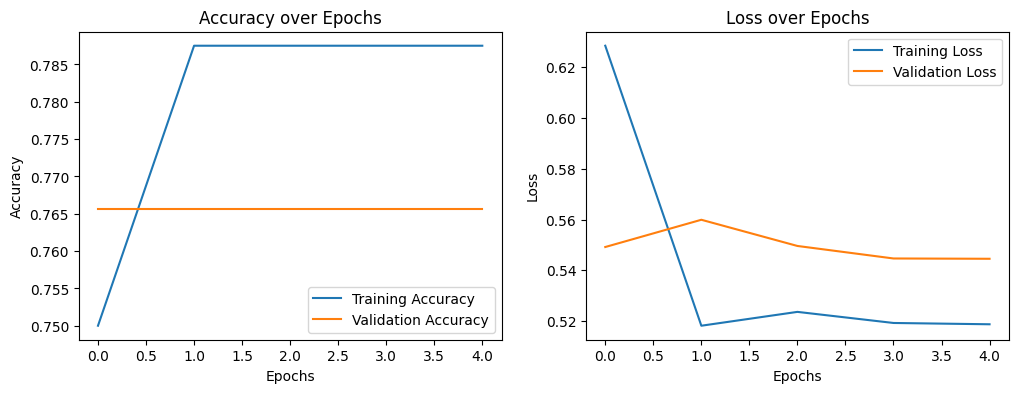

In [ ]:
import matplotlib.pyplot as plt
# Plotting training history
history = best_model.history_

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
